# Plotting Shear Distribution of Background Galaxies in DC2 Run 1.1p extra-galactic catalog (protoDC2)

In this example script we show how to select background galaxies distorted by the foreground host halo, and calculate their shear distributions.

Participants: **Ian Dell'Antonio**, **Robert Liu**, **Shenming Fu**

Last verified run: **7-26-18**

This notebook demonstrates how to access the extra galactic catalog through the Generic Catalog Reader (GCR, https://github.com/yymao/generic-catalog-reader) as well as how filter on galaxy features and cluster membership.

__Objectives__:

1. Access extra galactic catalog (ProtoDC2) through the GCR.
2. Select galaxy cluster centrals as a proxy for clusters.
3. Select background galaxies filtered by position and redshift.
4. Plotting tangential shear of the background galaxies vs. their distances to the host halo center.


__Logistics__: This notebook is intended to be run through the JupyterHub NERSC interface available here: https://jupyter-dev.nersc.gov. To setup your NERSC environment, please follow the instructions available here: https://confluence.slac.stanford.edu/display/LSSTDESC/Using+Jupyter-dev+at+NERSC

In [ ]:
import GCRCatalogs
import numpy as np
import math
from scipy import stats
from astropy.table import Table
from GCR import GCRQuery
import matplotlib.pyplot as plt
%matplotlib inline

### Reading catalog
We load in the catalog with the "load_catalog" command, and then the values with the "get_quantities" command using filters to select sub-samples of the catalog.  

### Help for error messages:
If this fails to find the appropriate quantities, check that the desc-python kernel is being used and if this is not available source the kernels by running the following command on a terminal at nersc: "source /global/common/software/lsst/common/miniconda/setup_current_python.sh"

We are loading in the test version of the protoDC2 catalog - this contains the same information as the full catalog but it skips the md5sum check to save time. The resulting warning can be safely ignored. 

In [2]:
gc = GCRCatalogs.load_catalog('protoDC2_test')

/global/common/software/lsst/common/miniconda/py3-4.3.21-env/lib/python3.6/site-packages/GCRCatalogs/alphaq.py:105: UserWarning: No md5 sum specified in the config file
  warnings.warn('No md5 sum specified in the config file')


In [8]:
galaxy_data = gc.get_quantities(['ra', 'dec', 'mag_r', 'halo_id', 'shear1', 'shear2'], filters=['mag_r < 19'])
cluster_data = gc.get_quantities(['ra','dec', 'halo_mass', 'halo_id'], 
                                 filters=['is_central', 'halo_mass > 1e14', 'redshift < 0.2'])
#sorted(c for c in gc.list_all_quantities(True) )

### Plot individual clusters
The cluster_data we loaded selects for central galaxies in clusters of mass higher than 10^14 solar masses/h below redshift 0.2. We will plot three such clusters in the proto-DC2 region. 

For each of these clusters we can match the galaxies by selecting on 'halo_id' and make a scatter plot of the projected positions around the central galaxy. Note that the size of the circles corresponds to the r-band magnitude of the galaxies. 

The cluster data is cast into a familiar astropy table.

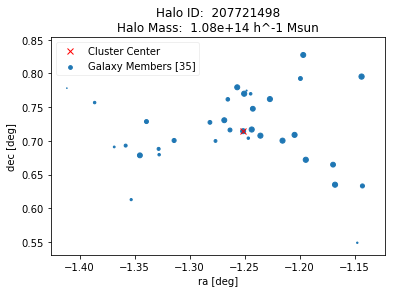

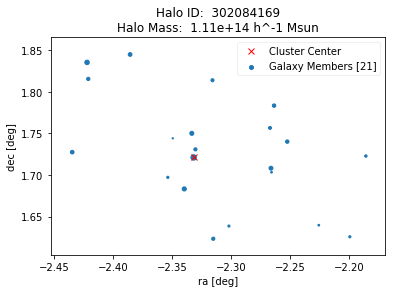

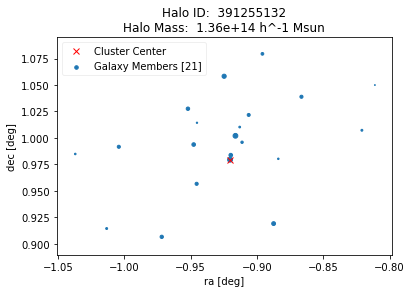

In [9]:
cluster_data = Table(cluster_data)
for i, cluster in enumerate(cluster_data):
    if (i >= 3):
        break # plot only the first 3
    
    
    
    members = GCRQuery('halo_id == {}'.format(cluster['halo_id'])).filter(galaxy_data)
    plt.figure()
    plt.scatter(
        members['ra'], 
        members['dec'], 
        s=(19-members['mag_r'])*8, 
        label='Galaxy Members [{}]'.format(len(members['ra']))
    )
    plt.plot(cluster['ra'], cluster['dec'], 'xr', label='Cluster Center')
    plt.legend(loc='best', framealpha=0.3)
    plt.xlabel(r'ra [deg]')
    plt.ylabel(r'dec [deg]')
    plt.title('Halo ID:  {}\nHalo Mass:  {:.2e} h^-1 Msun'.format(cluster['halo_id'], cluster['halo_mass']))
        
plt.show()

### Extensions:
We can load further information on the cluster members. For instance the second cluster looks a little odd in projected space, so we re-make these plots in comoving cartesian coordinates x and y in the example below. We also map the colours to the x-direction velocities. 

To do this you need to load the required quantities from the catalog before using them. A simple way to double check the quantity names is the command "gc.list_all_quantities()".

In [6]:
galaxy_data = gc.get_quantities(['ra', 'dec', 'mag_r', 'halo_id', 'shear1', 'shear2', 'position_x', 'position_y', 
                                 'velocity_x', 'velocity_y'], filters=['mag_r < 24', 'redshift>0.3'])
cluster_data = gc.get_quantities(['ra','dec', 'halo_mass', 'halo_id', 'position_x', 'position_y'], 
                                 filters=['is_central', 'halo_mass > 1e14', 'redshift < 0.2'])

In [ ]:
cluster_data = Table(cluster_data)
galaxy_data = Table(galaxy_data)
nbins = 10

for i, cluster in enumerate(cluster_data):
    distarr = []
    etanarr = []
    if (i >= 4):
        break # plot only the first 3
        
    for source in galaxy_data:
        dist = math.hypot((source['ra']-cluster['ra']), (source['dec']-cluster['dec']))
        if(dist<0.3):
            theta = math.acos((source['ra']-cluster['ra'])/dist)
            cos2theta = math.cos(2.0*theta)
            sin2theta = math.sin(2.0*theta)
            etan = -1.0 * source['shear1'] * cos2theta - source['shear2'] * sin2theta
            distarr.append(dist)
            etanarr.append(etan)

    plt.scatter(distarr, etanarr, s=1)
    
#     x=np.array(distarr)
#     y=np.array(etanarr)
#     n, _ = np.histogram(x, bins=nbins)
#     sy, _ = np.histogram(x, bins=nbins, weights=y)
#     sy2, _ = np.histogram(x, bins=nbins, weights=y*y)
#     mean = sy / n
#     std = np.sqrt(sy2/n - mean*mean)

#     plt.plot(x, y, 'bo')
#     plt.errorbar((_[1:] + _[:-1])/2, mean, yerr=std, fmt='r-')
    
    plt.xlabel(r'distance to host halo center / deg')
    plt.ylabel(r'shear_tan')
    plt.show()
    
#     members = GCRQuery('halo_id == {}'.format(cluster['halo_id'])).filter(galaxy_data)
#     plt.figure()
#     plt.scatter(
#         members['position_x'],
#         members['position_y'],
#         s=(19-members['mag_r'])*8, 
#         label='Galaxy Members [{}]'.format(len(members['ra'])),
#         c=members['velocity_x'],
#         cmap='viridis')
#     plt.plot(cluster['position_x'], cluster['position_y'],'xr',label='Cluster Center', alpha=0.8)
#     plt.legend(loc='best',framealpha=0.3)
#     plt.xlabel(r'x [Mpc/h]')
#     plt.ylabel(r'y [Mpc/h]')
#     plt.title('Halo ID: {}\nHalo Mass: {:.2e}'.format(cluster['halo_id'], cluster['halo_mass']))
#     plt.colorbar(label='km/s')
# plt.show()

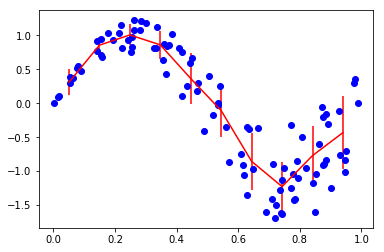

In [69]:
x = np.random.rand(100)
y = np.sin(2*np.pi*x) + 2 * x * (np.random.rand(100)-0.5)
nbins = 10

n, _ = np.histogram(x, bins=nbins)
sy, _ = np.histogram(x, bins=nbins, weights=y)
sy2, _ = np.histogram(x, bins=nbins, weights=y*y)
mean = sy / n
std = np.sqrt(sy2/n - mean*mean)

plt.plot(x, y, 'bo')
plt.errorbar((_[1:] + _[:-1])/2, mean, yerr=std, fmt='r-')
plt.show()